## Modified GA to Solve Single-Source Shortest Path 

This Modified GA inteds to iterate over the solution provided for the travelling salesman problem in order to solve the Single Source Shortes Path (SSSP) problem.

This algorithm has a limitation. It does not scale well to large graphs. 

The hypotheses is that the mutation method depends on generating a new random path which is a slow process. The next iteration on this algorithm should attempt to resovle this, by changing the mutation method. 

In [167]:
import time 
import random
import numpy as np
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt

In [95]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))

In [59]:
def fit(p, g):
    return path_length(p, g) ** (-1)

In [65]:
# Function to define a single new random path from node s to node r
# in a network supplied as a Networkx graph 
# G: Graph / network as networkx
# s: Start node 
# r: Destination node 
def gen_path(G, s, r):
    path = [s]
    
    current = s
    while current != r: 
        # Neighbours exluding nodes in path 
        neighbours = [n for n in G[current] if n not in path]
        
        # Sometimes, neighbours is empty 
        # In which case, retry 
        if not neighbours:
            return gen_path(G, s, r)
        
        # Select neighbour node with uniform probability  
        nxt = np.random.choice(neighbours) 
        
        # List and visit next node 
        path.append(nxt)
        current = nxt 
        
    return path

In [37]:
# Function to generate a population of n random paths s->r
# G: Graph as networkx
# s: Start node
# r: Destination node
# n: Number of paths / size of population 
def gen_population(G, s, r, n):
    population = [] 
    for i in range(n):
        # Generate a new candidate path
        candidate = gen_path(G, s, r)
        # Generate a new candidate 
        population.append(candidate)
    
    return population

In [77]:
# Perform crossover between two paths s->r
# The two paths must have at least one common element 
# From the set of common elements, one is selected, v 
# The paths are redifined as s -> v, v -> r  
# The path segments are recombined to create two children
# a: The first path
# b: The second path 
def crossover(a, b):
    common = [] 
    for ind_a, i in enumerate(a):
        for ind_b, j in enumerate(b):
            if i == j:
                common.append((ind_a, ind_b))
    
    # Randomly select a one common element to exchange
    target = np.random.choice(len(common))
    
    # Retrieve indexes
    ind_a, ind_b = common[target]
    
    # Create new arrays
    chd_a = a[:ind_a] + b[ind_b:]
    chd_b = b[:ind_b] + a[ind_a:]
    
    return chd_a, chd_b

In [90]:
def mutate(G, path):
    # Select a random element in path, v
    ind = np.random.choice(len(path) - 1)
    
    # Create a new random path from v to destination 
    v = path[ind]
    rnd_path = gen_path(G, v, path[-1])
    
    return path[:ind] + rnd_path

In [60]:
# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)

In [61]:
# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])

In [191]:
# threshold: Number of iterations with unchanged best fitness before exit 
# itr: Maximum number of iterations before quit 
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# s: start node in path 
# d: destination node in path
# g; graph 
def ga(G, threshold, itr, p, r, m, s, d):
    # Store the history of max and mean fitness for generations 
    history = []
    
    # Take starting time 
    start = time.time()
    
    # Generate a random population 
    # Graph; start node; dest node; size of population 
    population = gen_population(G, s, d, p) 
    fitness, fmax, ftotal, favg = evaluate(population, G)
    
    # Track previo
    # Generations 
    count = 0
    unchanged = 0 
    while  (unchanged < threshold) and (count < itr):   
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            c, d = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(c) 
            gen.append(d)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = mutate(G, gen[i]) 
        
        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the current population fitness
        _fmax = fmax
        fitness, fmax, ftotal, favg = evaluate(population, G)
        
        # Check if maximum fitness solution has changed 
        if _fmax == fmax:
            unchanged += 1 
        else:
            unchanged = 0 # Reset when max fitness changes 
        
        # Increment generation count
        count += 1 
    
    # Return stats and performance 
    ind = np.argmax(fitness)
    runtime = time.time() - start 
    
    results = {"generations": count, "runtime": runtime,
               "learning_history": history, 
               "solution": population[ind], 
               "length": path_length(population[ind], G), 
               "fitness": fitness[ind]}
    
    return results 

**Test Algorithm**

In [ ]:
G = nx.erdos_renyi_graph(100, 0.4)
test = ga(G, TRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, 0,)

In [175]:
# Random graph to test
G_small = nx.erdos_renyi_graph(100, 0.4)
G_large = nx.erdos_renyi_graph(1000, 0.4)

# Assign edge weights 
for (i, j) in G_small.edges:
    G_small[i][j]['weight'] = np.random.randint(0, 100)

for (i, j) in G_large.edges:
    G_large[i][j]['weight'] = np.random.randint(0, 100)

# GA Hyperparameters 
THRESHOLD = 10          # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 100        # Maximum iterations 
P_SIZE = 100            # Size of population 
M_RATE = 0.01           # Mutation rate (percent of population to mutate)
R_RATE = 0.5            # Percent of population to select as parents

results_small = ga(G_small, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, 0, 63)
results_large = ga(G_large, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, 0, 563)

In [181]:
print("Results Small Graph")
print("Solution Path: ", results_small["solution"])
print("Generations: ", results_small["generations"])
print("Solution Fitness: ", results_small["fitness"])
print("Runtime: ", results_small["runtime"], "seconds")
print("Solution Pathlength: ", results_small["length"])

Results Small Graph
Solution Path:  [0, 79, 33, 63]
Generations:  10
Solution Fitness:  0.01282051282051282
Runtime:  0.2241072654724121 seconds
Solution Pathlength:  78


In [182]:
print("Results Large Graph")
print("Solution Path: ", results_large["solution"])
print("Generations: ", results_large["generations"])
print("Solution Fitness: ", results_large["fitness"])
print("Runtime: ", results_large["runtime"], "seconds")
print("Solution Pathlength: ", path_length(results_large["solution"], G_large))

Results Large Graph
Solution Path:  [0, 995, 905, 506, 952, 935, 891, 100, 563]
Generations:  15
Solution Fitness:  0.0022675736961451248
Runtime:  137.47371196746826 seconds
Solution Pathlength:  441


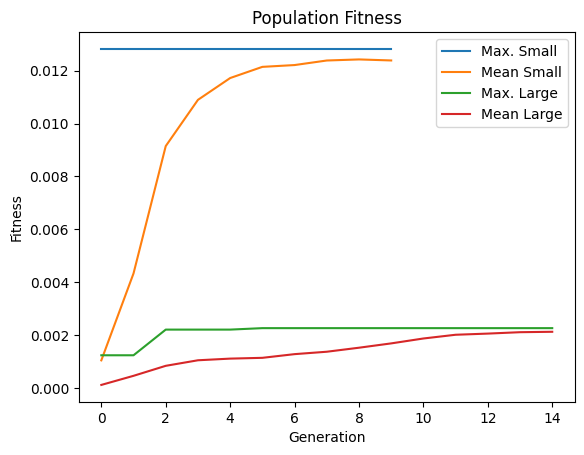

In [184]:
hist_small = results_small["learning_history"]
hist_large = results_large["learning_history"]

# history = [(max, average, total)] * number of generations 
# Plot the training history 
plt.figure()
plt.plot([x for x, y, z in hist_small])
plt.plot([y for x, y, z in hist_small])
plt.plot([x for x, y, z in hist_large])
plt.plot([y for x, y, z in hist_large])
plt.title("Population Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(("Max. Small", "Mean Small", "Max. Large", "Mean Large"))

**Draw the Shortest Path Found (Small Graph)**

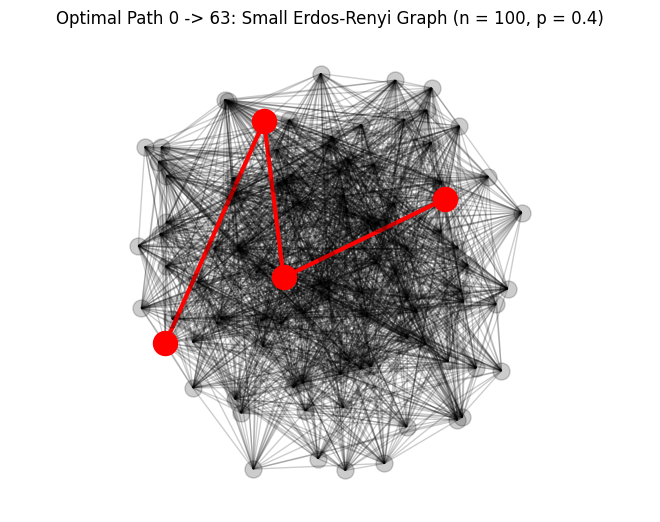

In [190]:
pos = nx.spring_layout(G_small)
nx.draw(G_small, pos, node_color='k', alpha = 0.2, node_size = 150)

# draw path in red
path = results_small["solution"]

# List edges in path as tuples (i, j)
path_edges = list(zip(path,path[1:]))

# Draw nodes and edges from network 
nx.draw_networkx_nodes(G_small, pos, nodelist = path, node_color='r')
nx.draw_networkx_edges(G_small, pos, edgelist = path_edges, edge_color='r', width = 3)

plt.title("Optimal Path 0 -> 63: Small Erdos-Renyi Graph (n = 100, p = 0.4)")
plt.axis('equal')
plt.show()